In [1]:

import pickle
import time

#basic
import pandas as pd
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

#tensorflow and keras
from tensorflow import keras
import tensorflow
from tensorflow.keras.layers import Input, Dense, GlobalAveragePooling2D, Flatten, MaxPooling2D, Dropout, Resizing, Rescaling, RandomBrightness, RandomContrast, RandomCrop, RandomFlip, RandomRotation
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras import Model
from keras.utils import load_img, img_to_array
from keras.models import load_model

#sklearn
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_transformer
from sklearn.metrics import confusion_matrix

#open cv
import cv2 as cv

from cascid.configs import config, pad_ufes
from cascid import database

RANDOM_STATE = 42
IMDIR = pad_ufes.IMAGES_DIR
IMAGE_SHAPE = (300, 300, 3)

2022-09-21 14:54:57.201011: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib/cuda/include:/usr/lib/cuda/lib64:
2022-09-21 14:54:57.201036: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
def modify_db(db: pd.DataFrame):
    db[['smoke','drink','pesticide','skin_cancer_history','cancer_history','has_piped_water','has_sewage_system','itch','grew','hurt','changed','bleed','elevation','biopsed']] = db[['smoke','drink','pesticide','skin_cancer_history','cancer_history','has_piped_water','has_sewage_system','itch','grew','hurt','changed','bleed','elevation','biopsed']].astype("bool")
    db = db.dropna().drop(['patient_id','lesion_id'], axis = 1)
    db['region'] = db['region'].apply(lambda x: 'OUTROS' if x in ['THIGH','LIP','FOOT','ABDOMEN','SCALP'] else x)
    db['background_father'] = db['background_father'].apply(lambda x: 'OUTROS' if x in ['ISRAEL','SPAIN','AUSTRIA','CZECH','BRASIL','POLAND','PORTUGAL','NETHERLANDS','NORWAY','FRANCE'] else ('BRAZIL' if x == 'BRASIL' else x))
    db['background_mother'] = db['background_mother'].apply(lambda x: 'OUTROS' if x in ['ISRAEL','SPAIN','AUSTRIA','CZECH','BRASIL','POLAND','PORTUGAL','NETHERLANDS','NORWAY','FRANCE'] else ('BRAZIL' if x == 'BRASIL' else x))
    db['is_cancer'] = db['diagnostic'].apply(lambda x: 0 if x in ['ACK','NEV','SEK'] else 1)
    # db.head(5).transpose()

    transformer = make_column_transformer((OneHotEncoder(categories='auto'), ['region','gender']), remainder='passthrough')
    transformed = transformer.fit_transform(db.drop(['diagnostic','biopsed','background_father','background_mother'], axis = 1))
    transformed_db = pd.DataFrame(transformed, columns=transformer.get_feature_names())
    transformed_db.loc[:, transformed_db.columns != 'img_id'] = transformed_db.loc[:, transformed_db.columns != 'img_id'].astype(np.float64)
    # transformed_db.head(5).transpose()
    return transformed_db


db = database.get_db()
transformed_db = modify_db(db)

/home/cedip/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [3]:
X = transformed_db.drop("is_cancer", axis = 1)
Y = transformed_db["is_cancer"].to_numpy().astype(np.float32)

In [4]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=RANDOM_STATE)

print("x_train shape: {0}".format(x_train.shape))
print("x_test shape: {0}".format(x_test.shape))
print("y_train shape: {0}".format(y_train.shape))
print("y_test shape: {0}".format(y_test.shape))

x_train = x_train.reset_index()
x_test = x_test.reset_index()

x_train_img = x_train["img_id"]
x_train_rfc = x_train.drop(["img_id"], axis=1)
x_test_img = x_test["img_id"]
x_test_rfc = x_test.drop(["img_id"], axis=1)

x_train shape: (1179, 30)
x_test shape: (295, 30)
y_train shape: (1179,)
y_test shape: (295,)


In [5]:
rfc_top = RandomForestClassifier(n_estimators=x_train.shape[1]*5, random_state=RANDOM_STATE)

def display_scores(scores):
    print('Scores:', scores.round(decimals=2))
    print('Mean:', scores.mean())
    print('Standard deviation:', scores.std())
    
    return scores.mean()

scores_rfc_top = cross_val_score(
    rfc_top,
    x_train_rfc,
    y_train,
    n_jobs=-1,
    scoring="roc_auc",
    cv=5
)

rfc_top.fit(x_train_rfc, y_train)
display_scores(scores_rfc_top)

Scores: [0.83 0.79 0.81 0.83 0.8 ]
Mean: 0.8126098307430274
Standard deviation: 0.014812220786743263


0.8126098307430274

In [6]:
NN = load_model(config.DATA_DIR / 'experiments' / 'fernando' / 'models' / 'deep_learning_effnet')
NN.treinable = False
NN.summary()

2022-09-21 14:55:07.999822: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-21 14:55:08.000248: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/cedip/.local/lib/python3.8/site-packages/cv2/../../lib64:/usr/lib/cuda/include:/usr/lib/cuda/lib64:
2022-09-21 14:55:08.000326: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/cedip/.local/lib/python3.8/site-packages/cv2/../../lib64:/usr/lib/cuda/include:/usr/lib/cuda/lib64:
2022-09-21 14:55:08.000397: W tensorflow/stream_executor/platform/default/ds

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 300, 300, 3)       0         
                                                                 
 efficientnetb3 (Functional)  (None, 1536)             10783535  
                                                                 
 dense (Dense)               (None, 32)                49184     
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense_1 (Dense)             (None, 32)                1056      
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 dense_2 (Dense)             (None, 16)               

In [7]:
class StackedModel():

    def __init__(self, NN: keras.models.Sequential, rfc: RandomForestClassifier) -> None:
        self.nn = NN
        self.rfc_top = rfc
        self.model = self._build_stacker_model()

    def _load_image(self, name: str):
        pil_img = load_img(
            str(IMDIR / name),
            grayscale=False,
            color_mode='rgb',
            target_size=(IMAGE_SHAPE[0], IMAGE_SHAPE[1]),
            interpolation='nearest',
            keep_aspect_ratio=False
        )

        return img_to_array(pil_img, dtype=np.uint8)

    def reader(self, img_path_list):
        return np.array(list(map(self._load_image, img_path_list)))

    def _build_stacker_model(self):
        # Return some model for prediction. This model is used to predict the final value, from the outputs of both input models.
        return RandomForestClassifier(n_estimators=50, random_state=RANDOM_STATE)
    
    def fit(self, x_train_rfc : np.ndarray, x_train_img : np.ndarray, y_train : np.ndarray) -> None:
        y_pred_nn = self.nn.predict(self.reader(x_train_img))
        y_pred_rfc = self.rfc_top.predict_proba(x_train_rfc)
        x_train_stack = np.hstack([y_pred_nn, y_pred_rfc])
        self.model.fit(x_train_stack, y_train)

    def predict(self, x_train_rfc : np.ndarray, x_train_img : np.ndarray, *args, **kwargs):
        y_pred_nn = self.nn.predict(self.reader(x_train_img))
        y_pred_rfc = self.rfc_top.predict_proba(x_train_rfc)
        x_pred_stack = np.hstack([y_pred_nn, y_pred_rfc])
        return self.model.predict(x_pred_stack, *args, **kwargs)       


In [8]:
StackModel = StackedModel(NN, rfc_top)

StackModel.fit(x_train_rfc, x_train_img, y_train)

preds = StackModel.predict(x_test_rfc, x_test_img)

preds

2022-09-21 14:56:08.042218: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 318330000 exceeds 10% of free system memory.
2022-09-21 14:56:10.380827: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 414720000 exceeds 10% of free system memory.
2022-09-21 14:56:10.445043: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 414720000 exceeds 10% of free system memory.
2022-09-21 14:56:10.589219: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 420268032 exceeds 10% of free system memory.


 1/37 [..............................] - ETA: 2:35

2022-09-21 14:56:12.958446: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 414720000 exceeds 10% of free system memory.


10/10 [==============================] - 26s 3s/step


array([1., 1., 1., 1., 1., 0., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 0., 1., 1., 0., 1., 1., 1.,
       1., 0., 1., 0., 1., 0., 1., 1., 1., 1., 0., 1., 0., 1., 1., 1., 1.,
       1., 1., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 0., 0.,
       0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 0.,
       1., 1., 1., 0., 1., 1., 0., 1., 1., 0., 1., 0., 1., 1., 1., 1., 1.,
       1., 0., 0., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 0.,
       1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 1., 1., 1., 1., 1., 1., 1.,
       1., 0., 1., 1., 1., 0., 1., 1., 1., 1., 0., 1., 0., 1., 1., 1., 0.,
       1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1.,
       0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 0., 0., 0.,
       1., 0., 1., 1., 1.

In [9]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=True,
                          title=None,
                          cmap=plt.cm.Greens, save_to_file = False):
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        #print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    #print(cm)

    fig, ax = plt.subplots(figsize = (16,16))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    if save_to_file:
        plt.savefig('Assets/files/' + title + '.pdf')
    return ax

<AxesSubplot:title={'center':'Normalized confusion matrix'}, xlabel='Predicted label', ylabel='True label'>

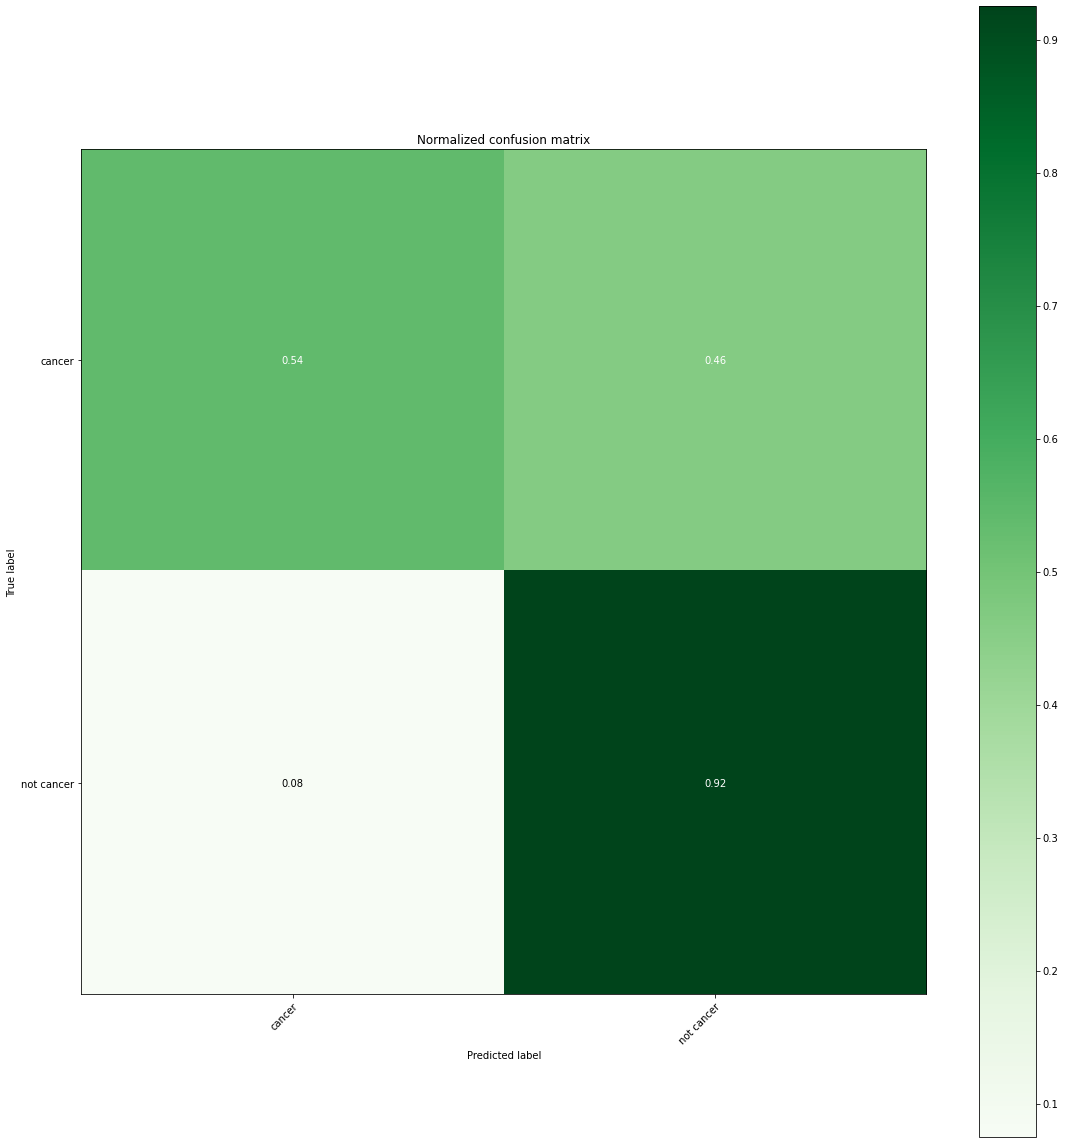

In [10]:
plot_confusion_matrix(y_test, preds, ["cancer", "not cancer"])